In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as Fun
import random
import pickle as pkl
import gzip

import games
import synthetic_data

In [2]:
class Evaluate:

    def __init__(self, ):
        pass

    def get_feedback(self, game, action, outcome ):
        return game.FeedbackMatrix[ action ][ outcome ]
        
    def deploy(self, game, horizon, alg, context_generator):

        history = [] 
        cumRegret =  []
        t = 0
        global_loss = []
        global_losses = []
        
        for t in range(horizon):
            
            context, distribution = context_generator.get_context()
            context = context.reshape( (1, -1) )
            outcome = np.argmax(distribution) 
            # distribution = np.array([1-outcome, outcome])
            #print('distribution', distribution, 'outcome', outcome, )

            #print('context shape',context.shape)
            action, data = alg.get_action(t, context)

            data['context'] = context 
            history.append( data )
            
            feedback =  self.get_feedback( game, action, outcome )

            loss, losses = alg.update(action, feedback, outcome, t, context )            

            global_loss.append(loss)
            global_losses.append(losses)

            i_star = np.argmin(  [ game.LossMatrix[i,...] @ np.array( distribution ) for i in range(alg.N) ]  )
            loss_diff = game.LossMatrix[action,...] - game.LossMatrix[i_star,...]
            val = loss_diff @ np.array( distribution )
            cumRegret.append( val )
            t+=1

            print('t', t, 'action', action, 'outcome', outcome, 'regret',val)
            print()
            
        return history, cumRegret, global_loss, global_losses

In [4]:
import cbpside
import rand_cbpside
import randneuralcbp
import cesa_bianchi
import random_algo
import random_algo2
import old_files.ineural as ineural
import ineural_multi
import margin_based
import neuralcbp_EE_kclasses

seed = 3
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

m = 100
H = 200
horizon = 1000

##### train and test data:

context_generator = synthetic_data.MNISTcontexts()

game = games.game_case3( )

# nclasses = 10
# alg = random_algo.Egreedy(game, nclasses, m, 'cuda:0')
# alg.reset(context_generator.d)

# lbd_neural = 0
# lbd_reg = 1
# sigma = 1/8
# K = 100
# epsilon = 10e-7
# alg = randneuralcbp.CBPside( game, 1.01, lbd_neural, lbd_reg, sigma, K, epsilon, m, H,  'cuda:0')
# alg.reset(context_generator.d)

# budget = 9999
# nclasses = 10
# alg = ineural_multi.INeurALmulti(budget, nclasses, 'cuda:0')
# alg.reset(context_generator.d)

lbd_neural = 0
lbd_reg = 1
nclasses = 10
alg = neuralcbp_EE_kclasses.CBPside( game, 1.01, lbd_neural, lbd_reg, m, H, nclasses,  'cuda:0')
alg.reset(context_generator.d)

evaluator = Evaluate()

num workers 1
input dim 8624
Net1 has 862,601 trainable parameters.
Net2 has 1,725,001 trainable parameters.


In [5]:
history, cumRegret, global_loss, global_losses = evaluator.deploy(game, horizon, alg, context_generator)

step 3 b
P_t 6 [1, 2, 5, 7, 8, 10] N_t [[1, 2], [1, 5], [1, 7], [1, 8], [1, 10], [2, 5], [2, 7], [2, 8], [2, 10], [5, 7], [5, 8], [5, 10], [7, 8], [7, 10], [8, 10]]
union1 [ 1  2  5  7  8 10] R [0]
t 1 action 0 outcome 5 regret 1

step 3 b
P_t 2 [2, 10] N_t [[2, 10]]
union1 [ 2 10] R [0]
t 2 action 0 outcome 9 regret 1

step 3 b
P_t 6 [1, 2, 3, 5, 7, 9] N_t [[1, 2], [1, 3], [1, 5], [1, 7], [1, 9], [2, 3], [2, 5], [2, 7], [2, 9], [3, 5], [3, 7], [3, 9], [5, 7], [5, 9], [7, 9]]
union1 [1 2 3 5 7 9] R [0]
t 3 action 0 outcome 9 regret 1

step 3 b
P_t 6 [1, 3, 4, 7, 9, 10] N_t [[1, 3], [1, 4], [1, 7], [1, 9], [1, 10], [3, 4], [3, 7], [3, 9], [3, 10], [4, 7], [4, 9], [4, 10], [7, 9], [7, 10], [9, 10]]
union1 [ 1  3  4  7  9 10] R [0]
t 4 action 0 outcome 0 regret 2

step 3 b
P_t 4 [2, 7, 8, 9] N_t [[2, 7], [2, 8], [2, 9], [7, 8], [7, 9], [8, 9]]
union1 [2 7 8 9] R [0]
t 5 action 0 outcome 5 regret 1

P_t 1 [2] N_t []
union1 [2] R []
t 6 action 2 outcome 9 regret 1

step 3 b
P_t 2 [2, 5] N_t

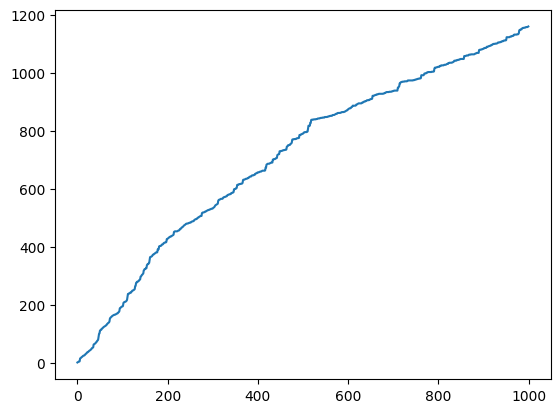

In [11]:
plt.plot( np.cumsum(cumRegret) )
# plt.ylim( (0,10000) )

(0.0, 1200.0)

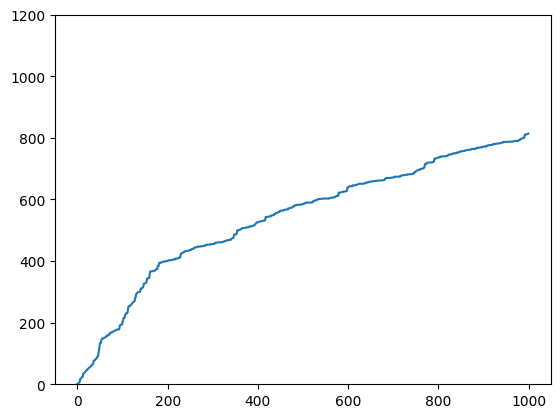

In [7]:
plt.plot( np.cumsum(cumRegret) )
plt.ylim( (0,1200) )

Text(0, 0.5, 'Loss')

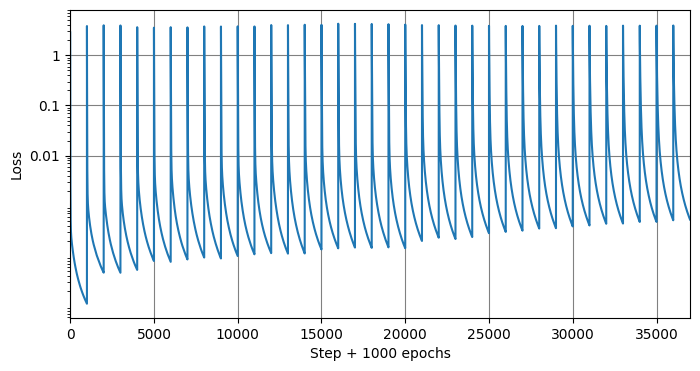

In [6]:
from matplotlib.ticker import ScalarFormatter

new_global_loss = np.hstack( [ i for i in global_loss if len(i)>0 ] )

plt.figure(figsize=(8, 4))
# plt.ylim( (0, 10) )
plt.yscale('log')
plt.grid(color='gray', linestyle='-')
plt.xlim( (-10, len(new_global_loss)) )


def generate_custom_ticks(start, horizon, end, increment, label_increment):
    custom_ticks = list(range(start, end+1 , increment))
    custom_tick_labels = [ str(i) for i in range(start, horizon , label_increment)]
    return custom_ticks, custom_tick_labels

# Define the parameters
start_value = 0
end_value = len(new_global_loss) 
tick_increment = 1000
label_increment = 50
horizon = 1000

# custom_ticks, custom_tick_labels = generate_custom_ticks(start_value, horizon, end_value, tick_increment, label_increment)

# plt.xticks(custom_ticks, custom_tick_labels, rotation=45, fontsize=7)

# Set tick locations and labels for the y-axis
tick_locations = [0.01, 0.1, 1, 10,]  # Define your desired tick locations
tick_labels = ['0.01', '0.1', '1', '10', ]  # Corresponding labels
ax = plt.gca()
ax.yaxis.set_major_locator(plt.FixedLocator(tick_locations))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticklabels(tick_labels)

plt.plot( new_global_loss )
plt.xlabel('Step + 1000 epochs')
plt.ylabel('Loss')

# plt.savefig('./figures/loss_evolution.png', dpi=380, bbox_inches='tight')


In [ ]:
context_generator = synthetic_data.QuinticContexts(  )
context_generator.set_b(0)
context_generator.normalization()

V_it_inv = np.identity(20)

vals = []
rates = []

T = 10000

for t in range(1,T):

    norm_context, distribution = context_generator.get_context(True)
    dist_test.append(distribution)
    outcome = np.random.choice( 2 , p = distribution ) 

    latent_X = alg.func( torch.from_numpy( norm_context ).float().to(alg.device) ).cpu().detach().numpy()

    V_it_inv = V_it_inv - ( V_it_inv @ latent_X.T @ latent_X @ V_it_inv ) / ( 1 + latent_X @ V_it_inv @ latent_X.T ) 

    val =  latent_X @ V_it_inv @ latent_X.T  
    rate = t**(2/3)  * ( 1.01 * np.log(t) )**(1/3)

    vals.append(val[0][0])
    rates.append(1/rate)

plt.plot(range(1,T), vals, '.' , markersize = 0.01, color = 'blue', label = 'pseudo-count')
plt.plot(range(1,T), rates, '.', markersize = 0.01, color = 'red', label = 'exploration threshold')
plt.yscale('log')
plt.legend()

NameError: name 'synthetic_data' is not defined